In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/accident-severity/accident severity classification.csv


# About Association Rules

Association rules is one of machine learning algorithms. It's most commoun name is "Market Basket Analysis", since it was widely used to find frequently co-purchased itemsets. However, its use cases expand beyond this. This notebook explores how Association Rules can be applied to a road accident dataset, in order to uncover the key factors leading to accidents.

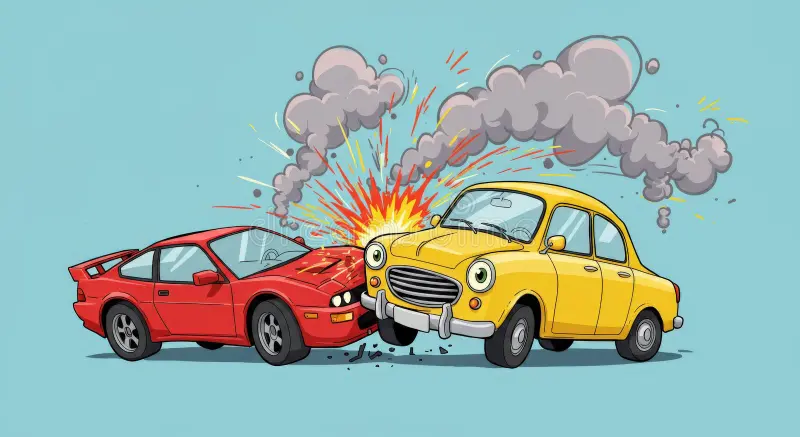

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Data

In [3]:
df= pd.read_csv('/kaggle/input/accident-severity/accident severity classification.csv')
df.head()

,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident,Accident_severity
0,18-30,Male,Above high school,Employee,1-2yr,Unknown,No junction,Asphalt roads,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,Not a Pedestrian,Moving Backward,2
1,31-50,Male,Junior high school,Employee,Above 10yr,Undivided Two way,No junction,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2
2,18-30,Male,Junior high school,Employee,1-2yr,other,No junction,Asphalt roads,Daylight,Normal,Collision with roadside objects,Going straight,Not a Pedestrian,Changing lane to the left,1
3,18-30,Male,Junior high school,Employee,5-10yr,other,Y Shape,Earth roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Changing lane to the right,2
4,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2


# Accident Severity Distribution

Text(0.5, 1.0, 'Accident Severity Distribution')

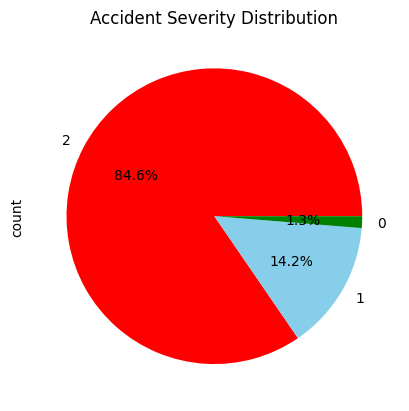

In [8]:
df['Accident_severity'].value_counts().plot.pie(
    autopct= '%1.1f%%',
    colors=['red','skyblue','green']
)
plt.title('Accident Severity Distribution')

The pie chart illustrates that the most frequent accident severity is level 2, accounting for 84.6% of cases. This is followed by severity level 1 at 14.2%, and severity level 0 at a mere 1.3%. This distribution helps explaining the absence of severity 0 in subsequent analysis using association rules.

# Missing values check 

In [4]:
df.isnull().sum()

Age_band_of_driver         0
Sex_of_driver              0
Educational_level          0
Vehicle_driver_relation    0
Driving_experience         0
Lanes_or_Medians           0
Types_of_Junction          0
Road_surface_type          0
Light_conditions           0
Weather_conditions         0
Type_of_collision          0
Vehicle_movement           0
Pedestrian_movement        0
Cause_of_accident          0
Accident_severity          0
dtype: int64

Although no missing values are shown, checking the dataset reveals some cells with "Unknown", "Unknown or other" values, which make them missing values. To treat them properly using Pandas library, they will be turned into NAN.

# Rename missing values

In [5]:
#replace "Unknown", "Unknow or other" cells with NAN
df.replace(["Unknown","Unknown or other"], np.nan, inplace =True)
#check NAN values
df.isnull().sum()

Age_band_of_driver         1548
Sex_of_driver               178
Educational_level           841
Vehicle_driver_relation     593
Driving_experience          829
Lanes_or_Medians            442
Types_of_Junction          1078
Road_surface_type           172
Light_conditions              0
Weather_conditions          292
Type_of_collision           169
Vehicle_movement            396
Pedestrian_movement         293
Cause_of_accident            25
Accident_severity             0
dtype: int64

# Cleaning missing values

In [6]:
#Mode imputation since most variables with missing values are categorial
df.fillna(df.mode().iloc[0],inplace=True)
df.isnull().sum()

Age_band_of_driver         0
Sex_of_driver              0
Educational_level          0
Vehicle_driver_relation    0
Driving_experience         0
Lanes_or_Medians           0
Types_of_Junction          0
Road_surface_type          0
Light_conditions           0
Weather_conditions         0
Type_of_collision          0
Vehicle_movement           0
Pedestrian_movement        0
Cause_of_accident          0
Accident_severity          0
dtype: int64

# Association Rules

In [7]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


# Convert rows into transactions (e.g., "Sex_of_driver=Male")
transactions = df.apply(
    lambda row: [f"{col}={row[col]}" for col in df.columns], axis=1
).tolist()

# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
# Frequent itemsets using fpgrowth (faster than apriori)
frequent_itemsets = fpgrowth(df_encoded, min_support=0.05, use_colnames=True)

# Generate all association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Strict filtering: only keep rules with EXACTLY ONE consequent,
# and that consequent must start with "Accident_severity="
rules = rules[
    (rules['consequents'].apply(len) == 1) &
    (rules['consequents'].apply(lambda x: list(x)[0].startswith("Accident_severity=")))
]

rules.to_csv(r'C:\Users\m\Downloads\associations_rules.csv', index=False)
rules = rules.sort_values(by='lift', ascending=False)
# Show the final filtered rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

                                               antecedents  \
841228   (Weather_conditions=Normal, Lanes_or_Medians=T...   
1215085  (Age_band_of_driver=18-30, Road_surface_type=A...   
1214999  (Age_band_of_driver=18-30, Road_surface_type=A...   
1214425  (Age_band_of_driver=18-30, Road_surface_type=A...   
1214963  (Vehicle_driver_relation=Employee, Age_band_of...   
...                                                    ...   
656940   (Lanes_or_Medians=Undivided Two way, Sex_of_dr...   
62168    (Lanes_or_Medians=Two-way (divided with broken...   
400875   (Road_surface_type=Asphalt roads, Sex_of_drive...   
615462   (Lanes_or_Medians=Two-way (divided with broken...   
875184   (Types_of_Junction=Y Shape, Light_conditions=D...   

                   consequents   support  confidence      lift  
841228   (Accident_severity=1)  0.051478    0.154333  1.090514  
1215085  (Accident_severity=2)  0.051640    0.911175  1.077487  
1214999  (Accident_severity=2)  0.054238    0.910082  1.0761

Since the apriori algorithm takes more running time and generates more rules, fpgrowth was implemented instead. The results show 7618 rules, which were sorted according to the highest lift value, which should exceed 1 to consider the rule significant.

Since there are many variables as antecedents, the entire rule would not be clear; therefore, it is better to save the outputs as a CSV or Excel file in order to easily read the outputs. 

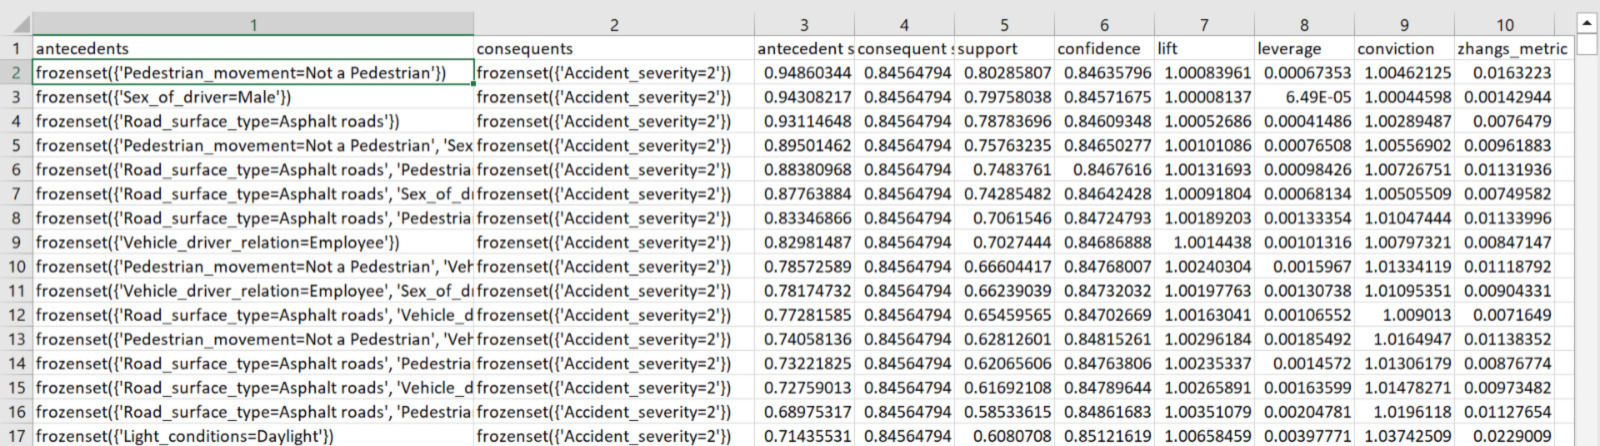

# Rules Visualization

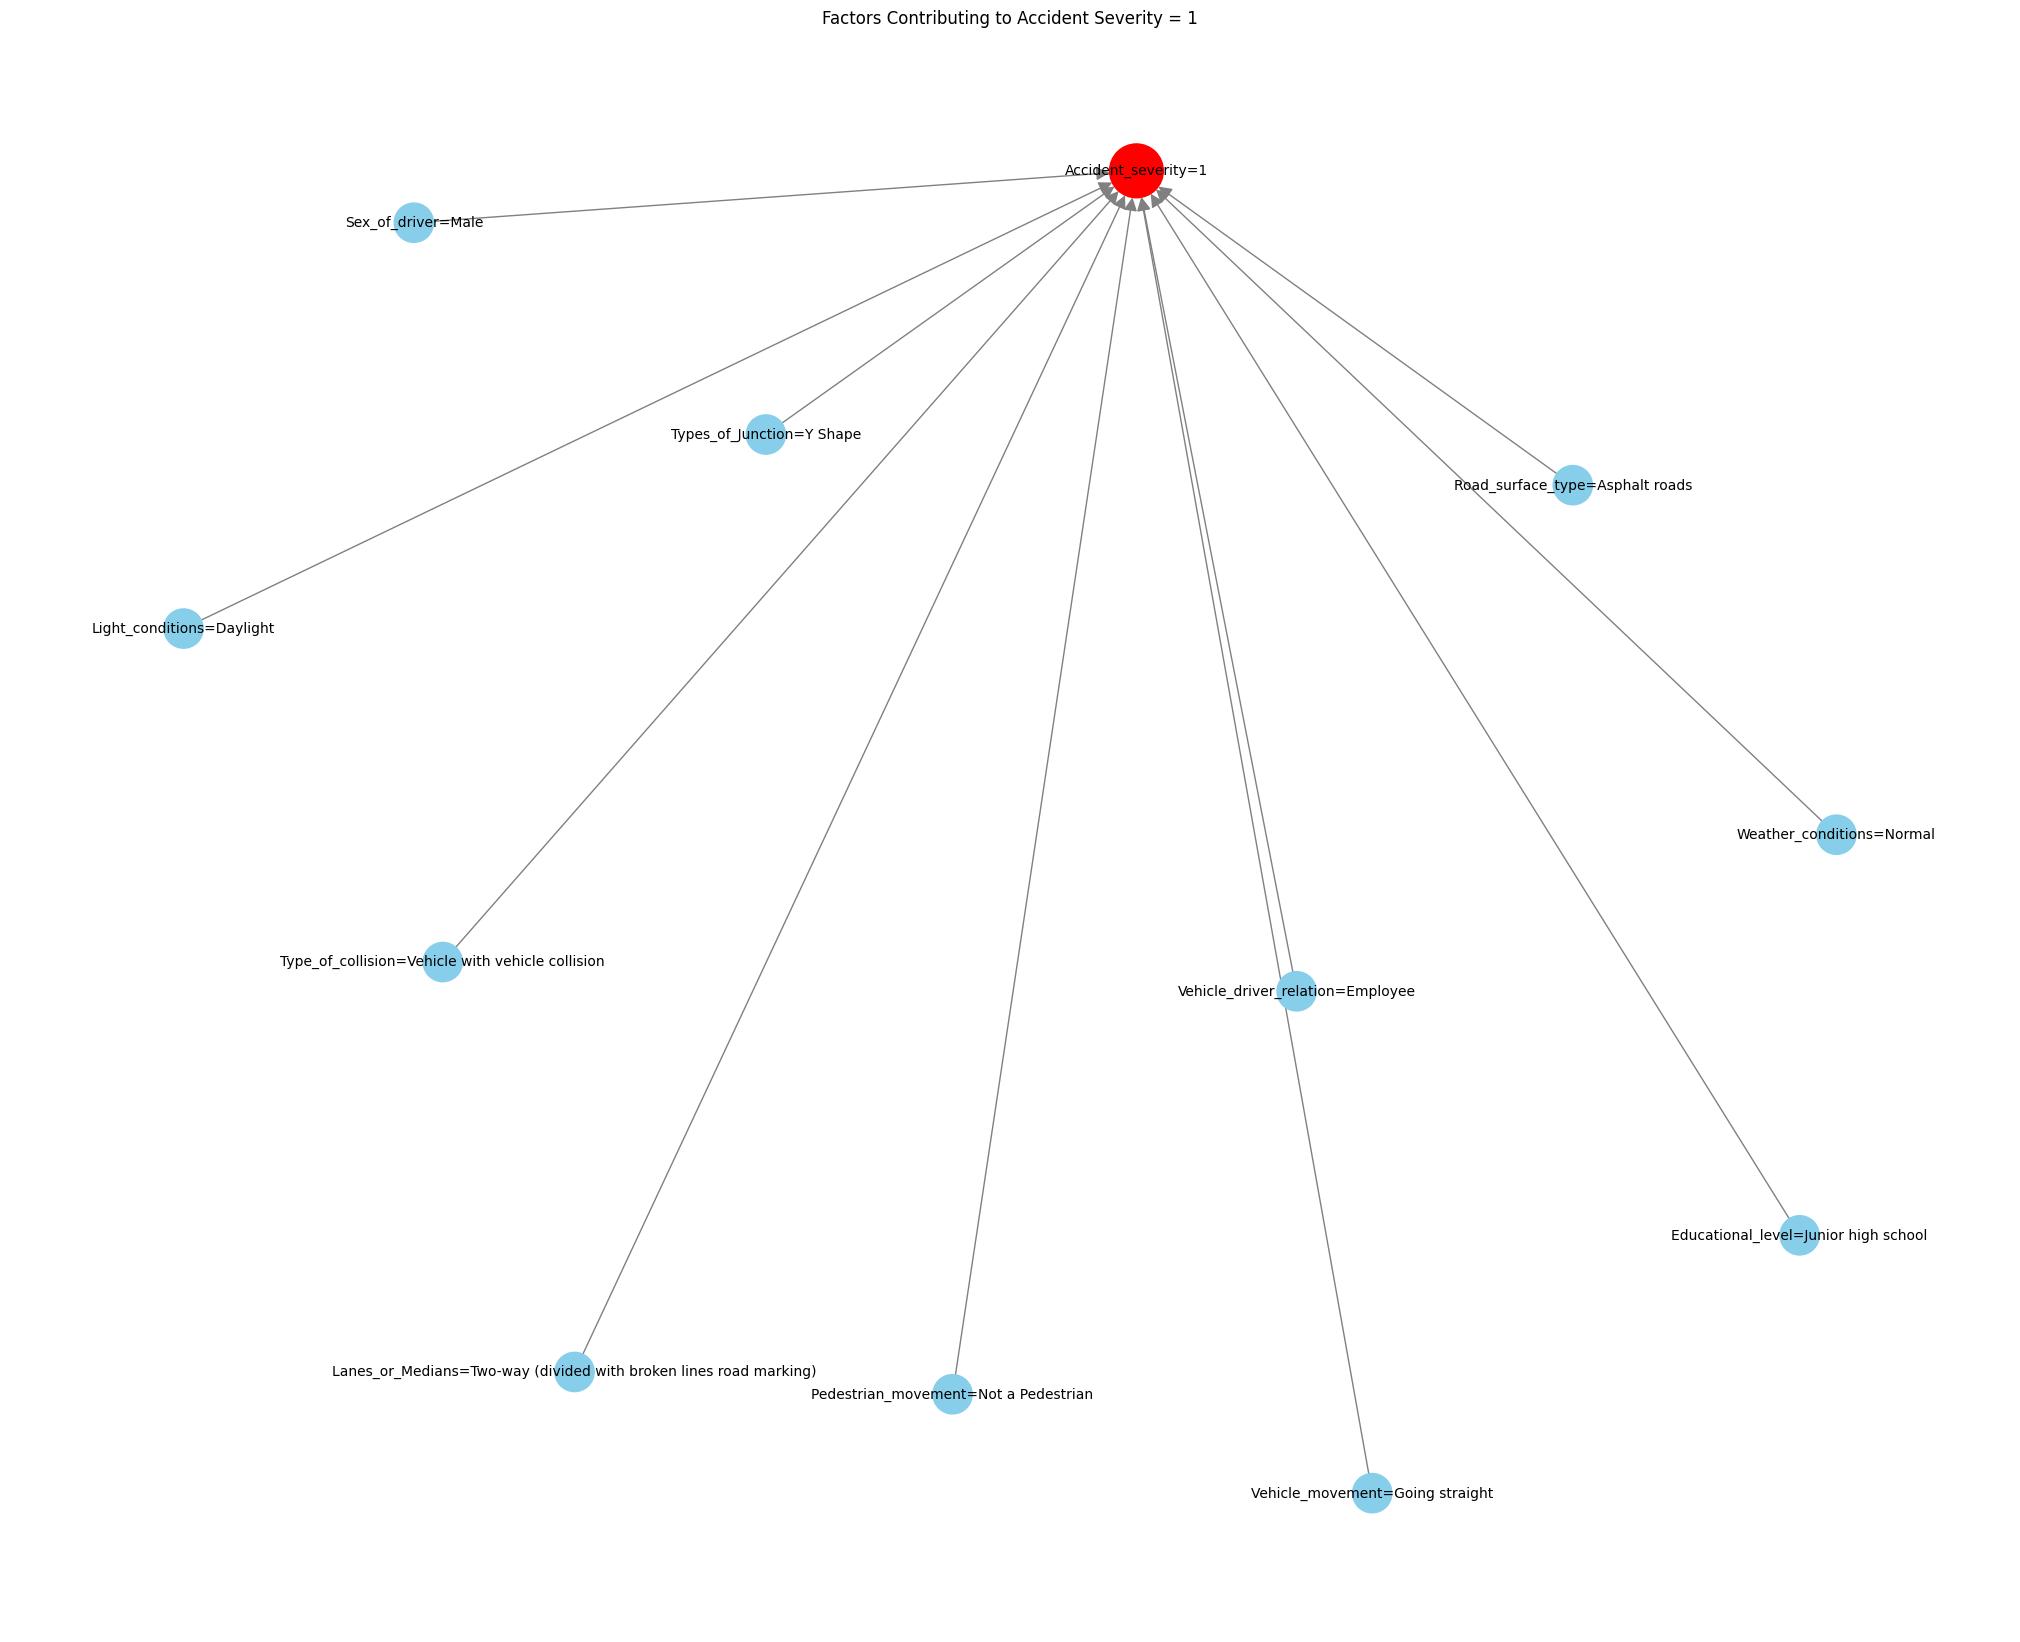

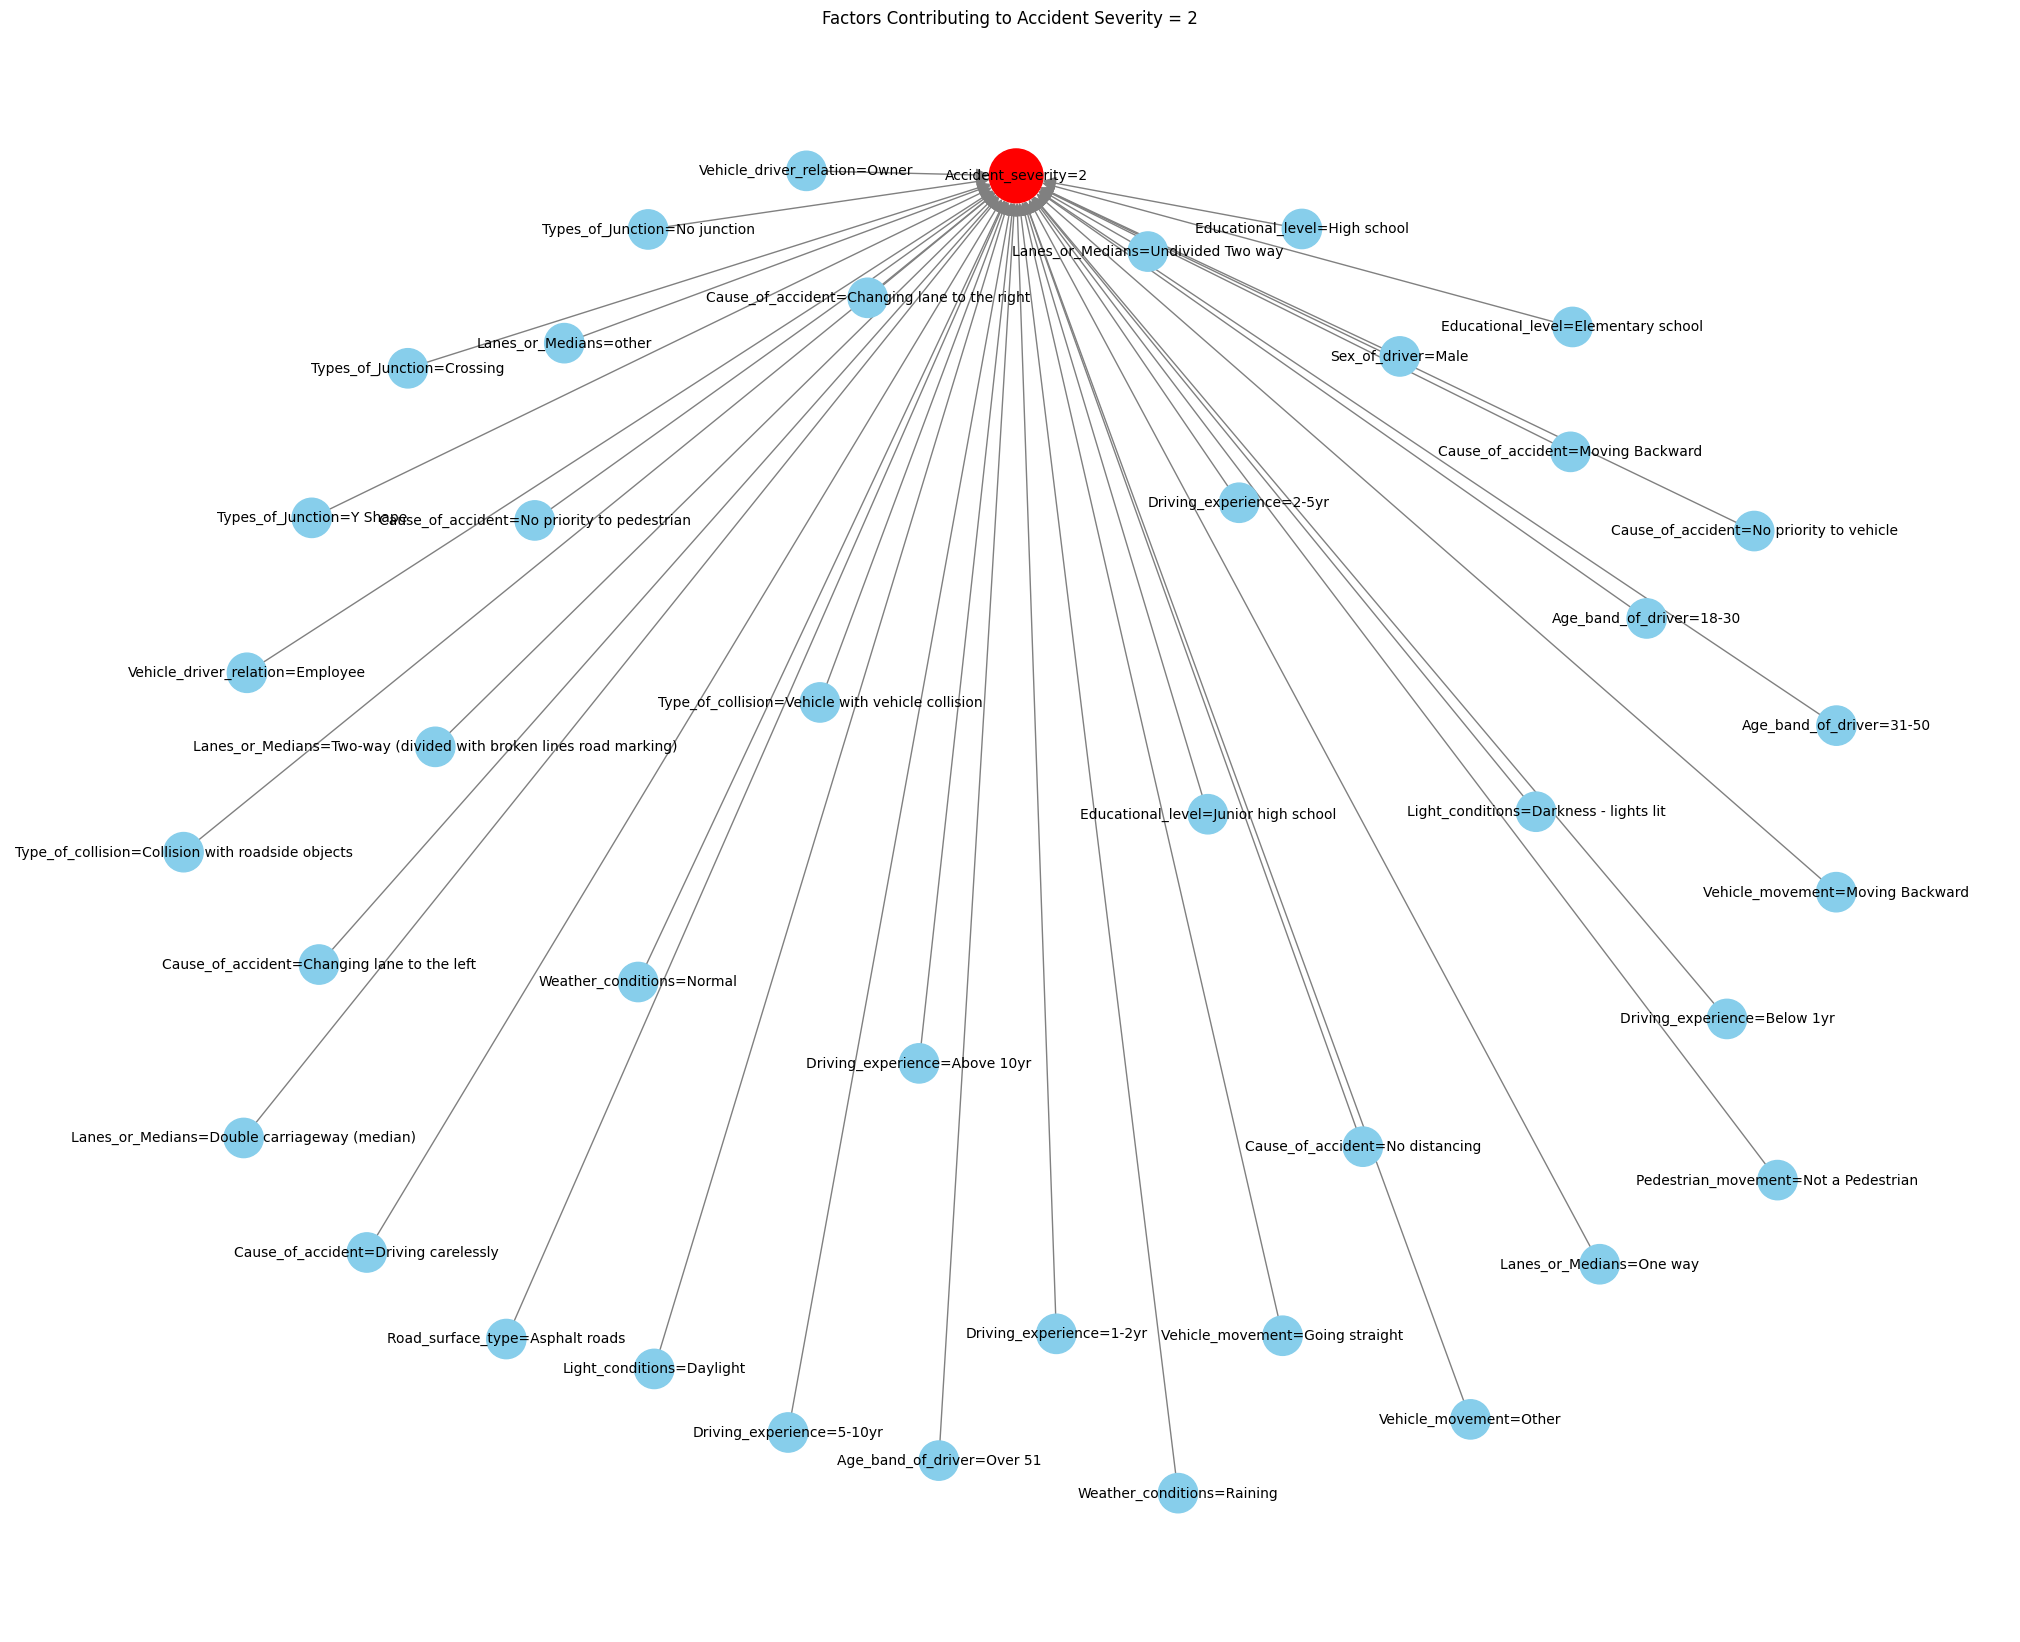

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_severity(severity, rules):
    G = nx.DiGraph()
    target = f"Accident_severity={severity}"
    G.add_node(target, color='red', size=1500)

    for _, row in rules.iterrows():
        if target in row['consequents']:
            for a in row['antecedents']:
                G.add_node(a, color='skyblue', size=800)
                G.add_edge(a, target)

    pos = nx.spring_layout(G, k=0.9, seed=42)
    node_colors = [G.nodes[n]['color'] for n in G]
    node_sizes = [G.nodes[n]['size'] for n in G]

    plt.figure(figsize=(20, 16))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes,
            font_size=10, edge_color='gray', arrowsize=20)
    plt.title(f"Factors Contributing to Accident Severity = {severity}")
    plt.show()

plot_severity(1, rules)
plot_severity(2, rules)


Visualizing the rules in a network makes them easier to understand and interpret, especially since the number of generated rules surpasses 7000. This number is likely to increase when using other algorithms, such as Apriori, or dealing with larger datasets. These results can provide governments and insurance companies with insights into the most important factors causing road accidents, helping them take preventive measures.